<a href="https://colab.research.google.com/github/shinmiura/diveintocode-ml/blob/master/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sprintの目的**

コンピュータビジョンの代表的タスクであるセグメンテーションを学ぶ

**どのように学ぶか**

公開されている実装を用いてKaggleコンペティションのデータでセグメンテーションを行います。

# 2.セグメンテーション

KaggleのTGS Salt Identification Challengeのデータセットを使用し、セグメンテーションを行います。


TGS Salt Identification Challenge | Kaggle


セグメンテーション手法としてU-Net[1]を使います。


[1]O.Ronneberger, P.Fischer, T.Brox. U-Net: Convolutional Networks for Biomedical Image Segmentation. Medical Image Computing and Computer-Assisted Intervention (MICCAI), Springer, LNCS, Vol.9351: 234–241, 2015


https://arxiv.org/pdf/1505.04597.pdf

**【問題1】学習・推定**

以下のKeras実装を使用して学習・推定を行ってください。


zhixuhao/unet: unet for image segmentation


《GPU環境での学習》


大規模なデータセット、大きなモデルになるため、GPUを使用する必要があります。


《新たなデータセットの適用》


公開されている実装で用意されたものとは異なるデータセットを入力するための準備が必要です。

In [ ]:
%ls

competition_data/  data.py  main.py       README.md        unet_membrane.h5
data/              img/     model.py      trainUnet.ipynb  unet_membrane.hdf5
dataPrepare.ipynb  LICENSE  __pycache__/  U-net.ipynb


In [5]:
%cd /content/drive/My Drive/Colab Notebooks/unet-master

/content/drive/My Drive/Colab Notebooks/unet-master


In [6]:
# 大前提としてmain.pyが正常に動くことを確認しておく。
!python main.py

Using TensorFlow backend.





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/content/drive/My Drive/Colab Notebooks/unet-master/model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


2021-09-26 02:25:40.950442: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2021-09-26 02:25:40.955331: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2000179999 Hz
2021-09-26 02:25:40.955577: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5604902d0bc0 initialized for platform Host (thi

In [3]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import cv2
import os
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
plt.rcParams['figure.figsize'] = (12, 9)

Using TensorFlow backend.


In [ ]:
print(image_path_list)

[]


In [ ]:
%pwd

'/content/drive/My Drive/Colab Notebooks/unet-master'

In [ ]:
%ls

competition_data/  data.py  main.py       README.md        unet_membrane.h5
data/              img/     model.py      trainUnet.ipynb  unet_membrane.hdf5
dataPrepare.ipynb  LICENSE  __pycache__/  U-net.ipynb


In [13]:
# 画像パス一覧(今居る場所が変わってしまってエラーが何度か起きたため絶対パスに変更した)
#　相対パスの場合は右のように書く　image_path_list = glob.glob('competition_data/train/images/*')
image_path_list = glob.glob('/content/drive/My Drive/Colab Notebooks/unet-master/competition_data/train/images/*')
# データ格納用リスト
X_train = []
y_train = []

# 画像パスでループ
for image_path in image_path_list[:100]:
  # 画像
  image = cv2.resize(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)/255, (256, 256))
  X_train.append(image)
  # セグメンテーション領域
  mask = cv2.resize(cv2.imread(image_path.replace('images', 'masks'), cv2.IMREAD_GRAYSCALE)/255, (256, 256))
  y_train.append(mask)

# numpy配列化
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape, y_train.shape)

# 学習用に形整える
X_train = np.expand_dims(X_train, axis = -1) # axis=-1は一番最後の軸
y_train = np.expand_dims(y_train, axis = -1)
print(X_train.shape, y_train.shape)

(100, 256, 256) (100, 256, 256)
(100, 256, 256, 1) (100, 256, 256, 1)


In [2]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

In [ ]:
!pip install tensorflow==1.15.0
!pip install keras==2.2.4
!pip install keras-applications==1.0.7

     |████████████████████████████████| 412.3 MB 26 kB/s 
     |████████████████████████████████| 50 kB 9.0 MB/s 
     |████████████████████████████████| 3.8 MB 61.9 MB/s 
     |████████████████████████████████| 503 kB 68.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=52362905eb94702b1f98f204f8c026f0b4b25170f1acd8978a739801184901b1
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

     |████████████████████████████████| 312 kB 15.4 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0


     |████████████████████████████████| 51 kB 735 kB/s 
  Attempting uninstall: keras-applications
    Found existing installation: Keras-Applications 1.0.8
    Uninstalling Keras-Applications-1.0.8:
      Successfully uninstalled Keras-Applications-1.0.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 1.15.0 requires keras-applications>=1.0.8, but you have keras-applications 1.0.7 which is incompatible.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.15.0 which is incompatible.


In [8]:
# モデル定義
def unet(pretrained_weights = None, input_size = (256, 256, 1)):
  inputs = Input(input_size)
  # 出力サイズが変わらないようにpadding=sameでパディングを行う。
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size = (2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(drop5))
  merge6 = concatenate([drop4, up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv6))
  merge7 = concatenate([conv3, up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7) 
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv7))
  merge8 = concatenate([conv2, up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8) 
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv8))
  merge9 = concatenate([conv1, up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9) 
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same',  kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(input = inputs, output = conv10)

  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

  if(pretrained_weights):
    model.load_weights(pretrained_weights)
  
  return model

model = unet()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [18]:
# 学習
model_checkpoint = ModelCheckpoint('unet_membrane.h5', monitor = 'loss', verbose = 1, save_best_only = True)
model.fit(X_train, y_train, batch_size =3, epochs = 100, callbacks = [model_checkpoint])

Epoch 1/100
100/100 [==============================] - 5s 46ms/step - loss: 0.6068 - acc: 0.7220

Epoch 00001: loss improved from inf to 0.60675, saving model to unet_membrane.h5
Epoch 2/100
100/100 [==============================] - 5s 47ms/step - loss: 0.5836 - acc: 0.7220

Epoch 00002: loss improved from 0.60675 to 0.58365, saving model to unet_membrane.h5
Epoch 3/100
100/100 [==============================] - 5s 46ms/step - loss: 0.5780 - acc: 0.7220

Epoch 00003: loss improved from 0.58365 to 0.57799, saving model to unet_membrane.h5
Epoch 4/100
100/100 [==============================] - 5s 46ms/step - loss: 0.5726 - acc: 0.7220

Epoch 00004: loss improved from 0.57799 to 0.57256, saving model to unet_membrane.h5
Epoch 5/100
100/100 [==============================] - 5s 46ms/step - loss: 0.5753 - acc: 0.7220

Epoch 00005: loss did not improve from 0.57256
Epoch 6/100
100/100 [==============================] - 5s 47ms/step - loss: 0.5560 - acc: 0.7220

Epoch 00006: loss improved fr

In [19]:
# 推定
y_pred = model.predict(np.array([X_train[0, :, :]]))

In [20]:
print(y_train[0].shape)
print(y_pred[0, :, :, 0].shape)

(256, 256, 1)
(256, 256)


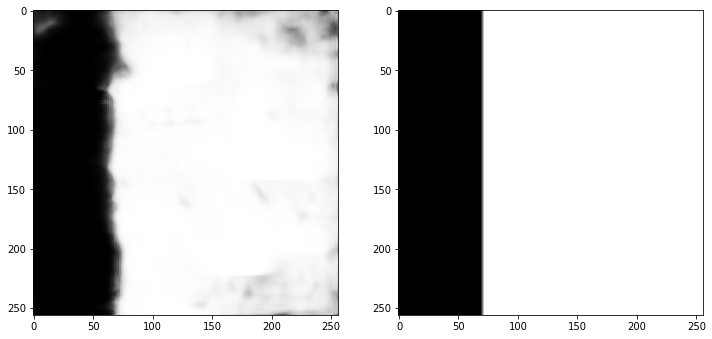

In [21]:
fig, ax = plt.subplots(1, 2)
# 上記のようにaxを生成した後は、ax.XXXを用いれば様々な種類のグラフが描画できる
ax[0].imshow(y_pred[0, :, :, 0], cmap = 'gray')
# 上記のとおりy_trainが3次元になっているため次元削減を行う
ax[1].imshow(np.squeeze(y_train[0]), cmap = 'gray')

**【問題2】コードリーディング**

論文[1]に目を通した上で、上記実装のコードリーディングを行ってください。

〈前提の確認〉

コードリーディングとは「名前の調査」である。

ソースコードは、「ファイル名・関数名・変数名・型名・メンバ名」といった名前の集合。

それぞれの名前が、何を表しているかを理解することこそがコードリーディングとここでは定義する。

drop5まででエンコードしている。ここで、入力された画像を何度か畳み込みして、その画像の特徴を抽出する。

up6以降でデコードしている。上記で抽出された特徴を受け取って、逆畳み込みの処理を行い、入力画像と同じサイズの確率マップを出力する。

merge6〜9では、ダウンサンプリングされた特徴マップを、Decorder側の対応する空間解像度の場所に受け渡す(スキップ接続する)ことで、ダウンサンプリングの際に失われてしまう情報の回復をしている。

